# Final Assignment

In this assignment, you will build a relation extraction model for scientific articles based on the [ScienceIE dataset](https://scienceie.github.io/) in a group of up to 3 students. This is the same dataset that was used for Assignment 2, where you had to train a model to extract keyphrases. You are welcome to build on code any team member already wrote for Assignment 2.

You will build and train relation extraction models on the ScienceIE dataset. For this, you will also need to do data preprocessing to convert the ScienceIE data into a format suitable for training a relation extraction models. 

Your mark will depend on:

* your **reasoning behind modelling choices** made
* the correct **implementations** of your relation extraction models, and
* the **performance** of your models on a held-out test set.

To develop your model you have access to:

* The data in `data/scienceie/`. Remember to un-tar the data.tar.gz file.
* Libraries on the [docker image](https://cloud.docker.com/repository/docker/bjerva/stat-nlp-book) which contains everything in [this image](https://github.com/jupyter/docker-stacks/tree/master/scipy-notebook), including scikit-learn, torch 1.2.0 and tensorflow 1.14.0. 


As with the previous assignment, since we have to run the notebooks of all students, and because writing efficient code is important, your notebook should run in 10 minutes at most, including package loading time, on your machine.
Furthermore, you are welcome to provide a saved version of your model with loading code. In this case loading, testing, and evaluation has to be done in 10 minutes. You can use the dev set to check if this is the case, and assume that it will be fine for the held-out test set if so.

## Setup Instructions
It is important that this file is placed in the **correct directory**. It will not run otherwise. The correct directory is

    DIRECTORY_OF_YOUR_BOOK/assignments/2019/final_assignment/problem/
    
where `DIRECTORY_OF_YOUR_BOOK` is a placeholder for the directory you downloaded the book to. After you placed it there, **rename the file** to your UCPH ID (of the form `xxxxxx`). 

## General Instructions
This notebook will be used by you to provide your solution, and by us to both assess your solution and enter your marks. It contains three types of sections:

1. **Setup** Sections: these sections set up code and resources for assessment. **Do not edit these**. 
2. **Assessment** Sections: these sections are used for both evaluating the output of your code, and for markers to enter their marks. **Do not edit these**. 
3. **Task** Sections: these sections require your solutions. They may contain stub code, and you are expected to edit this code. For free text answers simply edit the markdown field.  

Note that you are free to **create additional notebook cells** within a task section. 

**Do not share** this assignment publicly, by uploading it online, emailing it to friends etc. 

**Do not** copy code from the Web or from other students, this will count as plagiarism.

## Submission Instructions

To submit your solution:

* Make sure that your solution is fully contained in this notebook. 
* **Rename this notebook to your UCPH ID** (of the form "xxxxxx"), if you have not already done so.
* Download the notebook in Jupyter via *File -> Download as -> Notebook (.ipynb)*.
* Upload the notebook to Absalon.


## <font color='green'>Setup 1</font>: Load Libraries
This cell loads libraries important for evaluation and assessment of your model. **Do not change it.**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#! SETUP 1
import sys, os
_snlp_book_dir = "../../../../"
sys.path.append(_snlp_book_dir) 
import math
from glob import glob
from os.path import isfile, join
from statnlpbook.vocab import Vocab
from statnlpbook.scienceie import calculateMeasures
import shutil
import string

## <font color='blue'>Task 1</font>: Convert dataset between standoff and IOB format

We want to work with [the ScienceIE dataset](https://scienceie.github.io) that can be found in the `data/scienceie/` directory of the repository.  This dataset comes with **standoff annotation** for keyphrases and relations between them.  This means that for each document in the dataset, there are two files: a `.txt` file with the raw sentences, and a `.ann` file with the annotated keyphrases.  

For example, this is one of the `.txt` files from the training set:

```
Failure of structural components is a major concern in the nuclear power industry and represents not only a safety issue, but also a hazard to economic performance. Stress corrosion cracking (SCC), and especially intergranular stress corrosion cracking (IGSCC), have proved to be a significant potential cause of failures in the nuclear industry in materials such as Alloy 600 (74% Ni, 16% Cr and 8% Fe) and stainless steels, especially in Pressurised Water Reactors (PWR) [1–5]. Stress corrosion cracking in pressurized water reactors (PWSCC) occurs in Alloy 600 in safety critical components, such as steam generator tubes, heater sleeves, pressurized instrument penetrations and control rod drive mechanisms [2,6,7]. Understanding the mechanisms that control SCC in this alloy will allow for continued extensions of life in current plant as well as safer designs of future nuclear reactors.
```

And this is the corresponding `.ann` file:

```
T1	Material 11 32	structural components
T2	Process 0 32	Failure of structural components
T3	Process 254 259	IGSCC
T4	Process 213 252	intergranular stress corrosion cracking
*	Synonym-of T4 T3
T5	Process 165 190	Stress corrosion cracking
T6	Process 192 195	SCC
*	Synonym-of T5 T6
T7	Material 367 376	Alloy 600
T8	Material 378 402	74% Ni, 16% Cr and 8% Fe
*	Synonym-of T7 T8
T9	Material 408 424	stainless steels
T10	Material 440 466	Pressurised Water Reactors
T11	Material 468 471	PWR
T12	Process 480 505	Stress corrosion cracking
T13	Material 509 535	pressurized water reactors
T14	Material 537 542	PWSCC
*	Synonym-of T13 T14
T15	Material 554 563	Alloy 600
T16	Material 603 624	steam generator tubes
T17	Material 626 640	heater sleeves
T18	Material 642 677	pressurized instrument penetrations
T19	Material 682 710	control rod drive mechanisms
T20	Material 762 765	SCC
T21	Material 774 779	alloy
T22	Material 835 840	plant
T23	Task 852 892	safer designs of future nuclear reactors
T24	Material 876 892	nuclear reactors
T25	Material 567 593	safety critical components
R1	Hyponym-of Arg1:T16 Arg2:T25	
R2	Hyponym-of Arg1:T17 Arg2:T25	
R3	Hyponym-of Arg1:T18 Arg2:T25	
R4	Hyponym-of Arg1:T19 Arg2:T25
```

Note: Besides keyphrases, which you are already familiar with from Assignment 2, the `.ann` files also contain relation annotations labeled `Hyponym-of` and `Synonym-of`. These are relations between keyphrases. 

`Synonym-of` is an undirected relation, meaning that if you see a line like this:

```*	Synonym-of T13 T14```

The order of keyphrases could be swapped, i.e. the following would also hold:

```*	Synonym-of T14 T13```

The evaluation script will thus be agnostic to the order in which the keyphrases between which `Synonym-of` relations hold are ordered.

`Hyponym-of`, on the other hand, is a directed relation, meaning that it is order-sensitive, and that the evaluation script will take the order of keyphrases between which `Hyponym-of` relations hold into account.

The `.ann` standoff format is **documented in [the brat documentation](http://brat.nlplab.org/standoff.html).**  
You may want to convert the format into some internal representation for training models; however, how you do that is up to you, i.e. you do not have to use IOB format like in Assignment 2. 

**Further Notes**:
- At training time, you you will be provided with plain text documents and `.ann` files with keyphrases and relations
- At test time, you will be provided with plain text documents and `.ann` files **with keyphrases only**. This is because your task is to predict relations.
- The evaluation script is agnostic to the order of relation triples and relation ids, but should preserve the ids of the keyphrases that will be used in the predicted relations. The evaluation scripts requres the entity annotations to be present as well in the prediction file.

In [3]:
### General modules
import pprint
from gensim.models import fasttext
from gensim.models import KeyedVectors
from copy import deepcopy
from collections import Counter
import numpy as np
import pandas as pd


### Our own modules
from Extra_files.modules.load_and_save import load_scienceie, save_to_ann, reformat_to_save
from Extra_files.modules.rules import _add_rules
from Extra_files.modules.confusion_matrix import plot_confusion_matrix
from Extra_files.modules.DataPreparation import entityLocator, addPOStoDic, addLemmatoDic, inputPair, WordEmbedder
from Extra_files.modules.MasterVocab import MasterVocab
from Extra_files.modules.scaling import downscale
from Extra_files.models.dummy_model import _sebastians_dummy_model

In [4]:
### LOAD THE DATA
pp = pprint.PrettyPrinter(indent=1,depth = None, compact = True).pprint
print("Loading dev_data...")
dev_data = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "dev"))
print("Loading train_data...")
train_data = load_scienceie(datadir=join(_snlp_book_dir, "data", "scienceie", "train"))

#print("Data example:")
#pp(dev_data['S0021999113005846'])


Loading dev_data...
Number of entities removed due to overlap: 269 out of 1330
Number of entities not identified in text: 1 out of 1061
Number of relations lost due to overlap: 10 out of 168
Removed references.
Concatenated 'i.e.' and 'e.g.'.
Loading train_data...
Number of entities removed due to overlap: 1337 out of 7405
Number of entities not identified in text: 28 out of 6068
Number of relations lost due to overlap: 50 out of 673
Removed references.
Concatenated 'i.e.' and 'e.g.'.


In [5]:
# GET SPACY HERE
if True:
    !python -m spacy download en
    import spacy
    nlp = spacy.load("en")
    nlp.tokenizer = nlp.tokenizer.tokens_from_list

You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.6/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [6]:
engbedder = WordEmbedder()
#engbedder.loadModel()
#engbedder.loadPCA()
engbedder.loadEmbedder() # loads both of the above in

PCA model loaded from Extra_files/resources/PCA.pkl


In [7]:
from pickle import load, dump

# data_m_XY = dataX_Y_format(train_data,indices = True) 
# dump(data_m_XY, open('Extra_files/resources/train_ind.pkl', 'wb'))
# data_m_XY_dev = dataX_Y_format(dev_data,indices = True)
# dump(data_m_XY_dev, open('Extra_files/resources/dev_ind.pkl', 'wb'))

data_m_XY = load(open('Extra_files/resources/train_ind.pkl', 'rb'))
data_m_XY_dev = load(open('Extra_files/resources/dev_ind.pkl', 'rb'))
train_keys = set(train_data.keys())
dev_keys = set(dev_data.keys())

if False:
    print(data_m_XY['metadata'][0])
    pp(data_m_XY['data_X'][0])
    print(data_m_XY['data_Y'][0])
    
    print(data_m_XY['Vocab'].transformX_toLabel(data_m_XY['data_X'][0]))

In [9]:
list(dev_data.keys())[0]

'S0009261408017028'

In [14]:
from Extra_files.modules.load_and_save import load_txt_str
datadir = join(_snlp_book_dir, "data", "scienceie", "dev")
txtfile = 'S0009261408017028.txt'
test_string = load_txt_str(txtfile,datadir)

data_X = dev_data[X]
#Get string all strings.

#For data_point in data:
    #Extract entities
        # For all combinations:
            #Find shortest path
                #Append (length, [path])
            


'We use open and close aperture Z-scan experiments, in analogy to the saturation absorption work discussed earlier in water [8], to respectively measure the β and n2 for a series of primary alcohols with the help of 1560nm femtosecond laser pulses, however, with the important inclusion of an optical-chopper. The vibrational combination states of the alcohols are coupled by the femtosecond laser pulses at 1560nm. These couplings result in the absorption of 1560nm and the excited molecules undergo relaxation through non-radiative processes, which gives rise to transient thermal effects. These transient thermal effects are related to the pure optical nonlinearity of the samples and can be measured as a change in their n2 values [14]. The transient thermal effects of individual pulses accumulate in case of high repetition-rate lasers to produce a cumulative thermal effect at longer timescales. We measure this cumulative thermal effect with the mode-mismatched two-color pump–probe experimen

In [23]:
#import spacy
#import networkx as nx
#nlp = spacy.load("en")
doc = nlp(u'Poor oxidation behavior is the major barrier to the increased use of Ti-based alloys in high-temperature structural applications. The demand to increase the service temperature of these alloys beyond 550°C (the typical temperature limit) requires careful study to understand the role that composition has on the oxidation behavior of Ti-based alloys [1–3]. The attempt to overcome this limitation in Ti-based alloys has led to the production of alloys with substantially improved oxidation resistance such as β-21S and also development of coatings and pre-oxidation techniques [1,4–6]. While it is tempting to extrapolate the oxidation behavior (e.g. oxidation rate law, depth of oxygen ingress and scale thickness) observed for a limited number of compositions under a certain oxidation condition to a broader compositional range, there are numerous examples in the literature where deviations from the expected relations are observed [7,8].')

# Load spacy's dependency tree into a networkx graph
edges = []
for token in doc:
    for child in token.children:
        edges.append(('{0}'.format(token.lower_),
                      '{0}'.format(child.lower_)))
graph = nx.Graph(edges)

# Get the length and path

entity1 = 'oxidation'.lower()
entity2 = 'barrier'

# Tag minimum mellem alle!
print(nx.shortest_path_length(graph, source=entity1, target=entity2))
print(nx.shortest_path(graph, source=entity1, target=entity2))

sentence:
3
['oxidation', 'behavior', 'is', 'barrier']


## <font color='blue'>Task 1.1</font>: Develop and Train a Relation Extraction Model with Gold Keyphrases

In this task, you develop a relation extraction model and apply it to the ScienceIE dataset.
As input to it, at test time, you will have the plain input texts as well as `.ann` files containing gold (i.e. correct) keyphrase annotations. The output should be `.ann` files containing relations between those keyphrases (you should include the keyphrase annotations in the output file as well).

A test input/output example is given in folders `data/scienceie/test/`,`data/scienceie/test_pred/`.

There are no strict requirements for how to design this model. You are expected to use the knowledge you have gathered throughout this course to design and implement this model. 

You are welcome to re-use existing code you might have written for other assignments as you see fit.

You are free to implement your solution in either PyTorch or Tensorflow, but if you are not sure where to start, we recommend looking at the [Keras API](https://keras.io) which is [integrated into Tensorflow 1.14.0](https://www.tensorflow.org/beta/guide/keras/overview?hl=en).

In [10]:
# You should improve this cell
from copy import deepcopy
def create_model(train_data, dev_data):
    """
    Return an instance of a relation extraction model defined over the dataset.
    Args:
        train_data: the training data the relation extraction detection model should be defined over.
        dev_data: the development data the relation extraction detection model can be tuned on.
    Returns:
        a relation extraction model
    """
    pass

def train_model(model, train_data, dev_data):
    """Train a relation extraction model on the given dataset.
    Args:
        model: The model to train
        data_train: The dataset to train on
        dev_data: the development data the relation extraction detection model can be tuned on
    """
    
    ### Reformat with Skjøtt's functions
    data_m_XY_train = dataX_Y_format(train_data,indices = True)
    data_m_XY_dev = dataX_Y_format(dev_data,indices = True)
    
    ### Extract X and Y
    train_X = data_m_XY_train['data_X']
    train_Y = data_m_XY_train['data_Y']
    dev_X = data_m_XY_dev['data_X']
    dev_Y = data_m_XY_dev['data_Y']
    
    #### TENSORFLOW MODEL (BEGIN) ------------------------------------------
    
    
    #### TENSORFLOW MODEL (END) --------------------------------------------
    
    return

def make_predictions(model, data, data_m_XY, seb = False,return_raw = False):
    """Makes predictions on a list of instances
    Args:
        model: The trained model
        data: The dataset to evaluate on
    Returns:
        The model's predictions for the data.
        If 'return_raw = True, it returns 'data_dict' (see below), else it returns reformatted data ready for saving.
    """
    
    ### Reformat and extract 'data_X'
    #data_m_XY = dataX_Y_format(data,indices = True)
    data_X = data_m_XY['data_X']   
    
    #### TENSORFLOW MODEL (BEGIN) ------------------------------------------
    if seb:
        data_m_XY['data_Y'] = _sebastians_dummy_model(data_m_XY,data)
    
    #### TENSORFLOW MODEL (END) --------------------------------------------
    
    
    #Add Sebastian's rules
    if not seb:
        data_m_XY = _add_rules(data_m_XY,data) #Hvis nogen er labelet, label alle
    
    
    ### Save in correct format
    if return_raw:
        return data_m_XY
    else:
        data = deepcopy(data)       
        save_format = reformat_to_save(data_m_XY)
        for txt in data:
            data[txt]['relations'] = save_format.get(txt,[]) #We might have txt's with no data after downscaling

        return data


In [15]:
from Extra_files.modules.error_analysis import plot_confusion_matrix, get_dataframe, plot_correct_labels
import pandas as pd
from pickle import load

data_m_XY = load(open('Extra_files/resources/train_ind.pkl', 'rb'))


In [16]:
y_base = np.array(make_predictions(_, train_data, deepcopy(data_m_XY), seb = True, return_raw = True)['data_Y'])
y_weak = np.array(make_predictions(_, train_data, deepcopy(data_m_XY), seb = False, return_raw = True)['data_Y'])
y_true = np.array(data_m_XY['data_Y'])

Number of forced synonyms: 10
Number of removed synonyms: 4
Number of removed hyponym-relations within list: 0
Number of labels changed to hyponyms: 33
Number of labels that would be changed but already in list of hyponyms: 260


In [18]:
from Extra_files.modules.error_analysis import plot_confusion_matrix, get_dataframe, plot_correct_labels

df_err_an = get_dataframe(train_data, data_m_XY, y_true, y_base, y_weak)

In [32]:
mask = [('i.e.' in df_err_an['Sentence between entities'][idx]) for idx in range(len(df_err_an))]
tmp = df_err_an[(df_err_an['True label'] != 'NONE') & mask]

In [33]:
np.array(tmp['Sentence between entities'])[10:16]

array(['complicated computational cell (i.e. Lees–Edwards cell',
       'simple cell (i.e. framed cell',
       'other approaches (i.e. i-vectors',
       'problem of dynamics, rewritten in first-order form, i.e. through a Hamiltonian description',
       'emission mechanism that can give tremendous power within a narrow range of the spectrum, is coherent (i.e. the same phase and direction) light lasers',
       'emission mechanism that can give tremendous power within a narrow range of the spectrum, is coherent (i.e. the same phase and direction) light lasers, which are called optical lasers'],
      dtype=object)

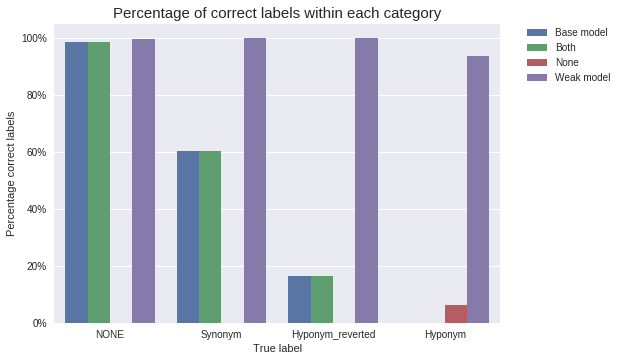

In [17]:
ax = plot_correct_labels(df_err_an)

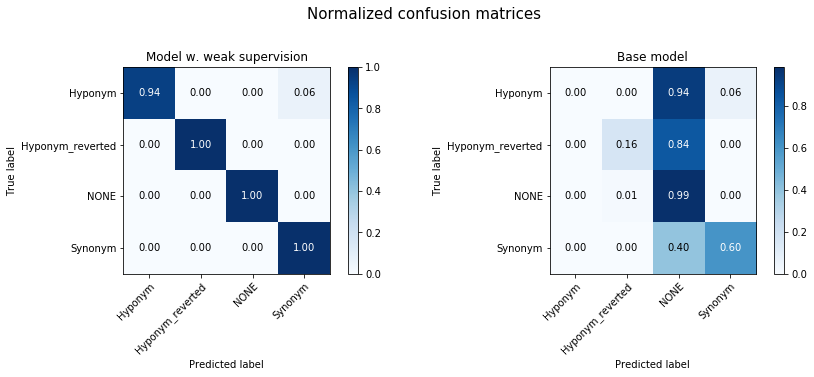

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig() #seaborn changes matplotlib default settings. 

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,3.8))

fig.suptitle('Normalized confusion matrices',y=1.1,fontsize = 15)
plot_confusion_matrix(y_true, y_weak, n_labels=None,normalize=True,ax = ax1)
ax1.set(title = 'Model w. weak supervision')
plot_confusion_matrix(y_true, y_base, n_labels=None,normalize=True, ax = ax2)
ax2.set(title = 'Base model')